In [1102]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload 

import cython
%load_ext Cython
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [1103]:
reload(ms_hm.MS)
reload(ms_hm.HM)
# importing MS and HM modules
import ms_hm 
from ms_hm.MS import *
from ms_hm.HM import *

In [1104]:
%%cython

import numpy as np
import cython
cimport numpy as np

cimport cython
ctypedef np.double_t DTYPE_t

from libc.math cimport exp
from libc.math cimport sqrt

from cython.parallel import prange

# find x_0 where the function y(x_0) = 0 
@cython.boundscheck(False)  # Deactivate bounds checking
cpdef zero_crossing(np.ndarray x_in, double [::1] y):
    cdef int size = x_in.shape[0]
    cdef double [:] x = x_in
    cdef double w, res=-1
    cdef int i
    for i in range(size-1):
        if(y[i] * y[i+1] < 0):
            w = abs(y[i] / (y[i+1] - y[i]))
            res = x[i] * (1 - w) + x[i+1] * w
            break
    return res

In [1105]:
# creating a mix of uniform and logarithmic grids
def mix_grid(left, right, n):
    A = np.exp(np.linspace(left, right, n))
    dA = A[1] - A[0]
    A = np.concatenate( (np.linspace(0, A[0],int(np.ceil(A[0] / dA)), endpoint=False), A))
    return A
# creating uniform grids
def uni_grid( right, n):
    A = np.linspace(0, np.exp(right), n)
    return A

In [1106]:
# some general set-ups
n=500 # number of grids

lower = -0.5
upper = 1.0
A = mix_grid(lower,upper,n)

w = 0.01
alpha = (2 / 3) * (1+w) # alpha = 1/2 for w = 1/3


rho0 = .01
t0 = alpha * np.sqrt(3 / (8*np.pi*rho0))
RH = t0 / alpha
Abar = A / RH

deltaL = 0

L = Abar[-1]
deltaA = Abar[1] - Abar[0]

# amp = 0.27337198
# delta0 = amp * np.exp(-Abar**2 / 2 /(1.6)**2)
# delta0P = amp * delta0 * 2 * (-1 / 2 / (1.6)**2 ) * Abar


# m = 1 + delta0 
# U = 1 - alpha * delta0 / 2
# R = 1 - alpha / 2 * (delta0 + w * Abar * delta0P / (1 + 3 * w) )


# ms = MS(R,m,U,w,alpha,A,rho0, trace_ray=True,BH_threshold=-1e100,dt_frac=0.05)

In [1107]:
# generate initial data for MS formula
def gen_init(amp):
    delta0 = amp * np.exp(-Abar**2 / 2 /(1.6)**2)
    delta0P = amp * delta0 * 2 * (-1 / 2 / (1.6)**2 ) * Abar


    m = 1 + delta0 
    U = 1 - alpha * delta0 / 2
    R = 1 - alpha / 2 * (delta0 + w * Abar * delta0P / (1 + 3 * w) )
    return (R, m, U)

In [1108]:
# Tell is is BH forms
# It evolves MS until it breaks. If 2m / R > 1, return true 
def BH_form(amp):
    
    (R, m, U) = gen_init(amp)

    ms = MS(R,m,U,w,alpha,A,rho0, trace_ray=False, BH_threshold=-999)
    if (ms.adap_run_steps(250000) == -1):
        return (True, ms.delta)
    return (False, ms.delta)

In [1109]:
# Binary search to find criticle amplitude (NOT the critical density)
# return (critical, upper value)
def find_crit():
    lower = 0.25
    upper = 0.28
    
    for i in range(20):
        mid = (lower + upper) / 2
        print('Iteration No ' + str(i))
        print('Trying with amplitude ' + str(mid))
        #(is_form, delta) = BH_form(mid)
        if(BH_form(mid)[0] == True):
            upper = mid
        else:
            lower = mid
    return ((upper + lower) / 2, upper)

In [1110]:
# Find mass of BHs for certain amplitude
def find_mass(amp, is_crit=False):
    print('Finding mass with amp ' + str(amp))
    (R, m, U) = gen_init(amp)
    ms = MS(R,m,U,w,alpha,A,rho0, trace_ray=False, BH_threshold=-1e1)
    ms.adap_run_steps(1500000, plot_interval=150000)
    delta = ms.delta
    ms = MS(R,m,U,w,alpha,A,rho0, trace_ray=True, BH_threshold=-1e100)
    flag = ms.run_steps(1500000)
    if(flag != 0):
        raise ValueError('Not finishing ray-tracing with the amplitude ' + str(amp))
    hm = HM(ms, mOverR=0.99, sm_sigma=50)
    flag = hm.adap_run_steps(550000)
    if(flag != 1 and is_crit == False):
        raise ValueError('Cannot get the target 2m/R with the amplitude ' + str(amp))
    print(ms.delta, hm.BH_mass2())
    return (ms.delta, hm.BH_mass2())

In [1111]:
# Generate critical scaling data 
def critical_scaling(crit_amp, lower_amp, upper_amp, n=10):
    amps = 10**np.linspace(np.log10(lower_amp - crit_amp), np.log10(upper_amp - crit_amp), n) + crit_amp
    print(amps)
    masses = np.array([find_mass(amp) for amp in amps])
    crit_delta = find_mass(crit_amp, is_crit=True)[0]
    
    return (masses, crit_delta)

Finding mass with amp 0.01
Not Tracing ray and NO excision will be performed!
Warning, the time step is too small!
Tracing ray is enabled and excision will be performed!
Warning!0.7328774950240154 nan


/Users/drewrosenblum/Documents/GitHub/criticalcollapse/ms_hm/MS.py:94: RuntimeWarning: overflow encountered in exp
  ep = np.exp(self.psi(r, p, Pprime))
/Users/drewrosenblum/Documents/GitHub/criticalcollapse/ms_hm/MS.py:102: RuntimeWarning: overflow encountered in multiply
  (   g**2 * np.concatenate( ([self.w
/Users/drewrosenblum/Documents/GitHub/criticalcollapse/ms_hm/MS.py:101: RuntimeWarning: invalid value encountered in multiply
  kU = U - self.alpha * ep * \
/Users/drewrosenblum/Documents/GitHub/criticalcollapse/ms_hm/MS.py:160: RuntimeWarning: invalid value encountered in multiply
  self.R = self.R + (deltau/6*(kR1 + 2*kR2 + 2*kR3 + kR4)) * exec_arr
/Users/drewrosenblum/Documents/GitHub/criticalcollapse/ms_hm/MS.py:161: RuntimeWarning: invalid value encountered in multiply
  self.m = self.m + (deltau/6*(km1 + 2*km2 + 2*km3 + km4)) * exec_arr
/Users/drewrosenblum/Documents/GitHub/criticalcollapse/ms_hm/MS.py:162: RuntimeWarning: invalid value encountered in multiply
  self.U = se

ValueError: Not finishing ray-tracing with the amplitude 0.01

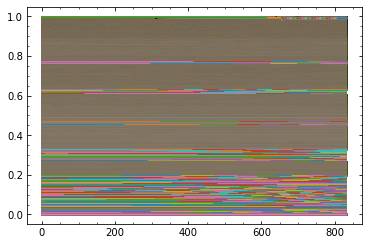

In [1112]:
amp=0.01
print('Finding mass with amp ' + str(amp))
(R, m, U) = gen_init(amp)
ms = MS(R,m,U,w,alpha,A,rho0, trace_ray=False, BH_threshold=-1e1)
ms.adap_run_steps(1500000)
delta = ms.delta
ms = MS(R,m,U,w,alpha,A,rho0, trace_ray=True, BH_threshold=-1e100)
flag = ms.run_steps(1500000)
if(flag != 0):
    raise ValueError('Not finishing ray-tracing with the amplitude ' + str(amp))

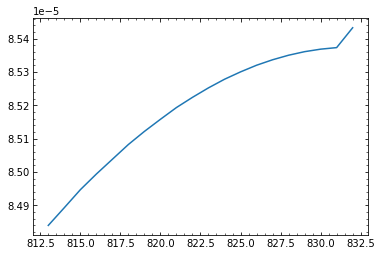

In [1046]:
R = ms.R # get the array of R values from the ms class, store in a shorthand "R" variable
m = ms.m # get the array of m values from the ms class, store in a shorthand "m" variable
U = ms.U # get the array of U values from the ms class, store in a shorthand "U" variable
xi = ms.xi # get the array of xi values from the ms class, store in a shorthand "xi" variable

r = ms.rho(R, m) # call the ms rho function to compute an array of rho values, store the array in the "r" variable
p = ms.P(r) # call the ms P function to compute an array of pressure values, store the array in the "p" variable
Pprime = ms.Pprime(R, m) # call the ms Pprime function to compute an array of P' values, store in the "Pprime" variable

psi = ms.psi(r, p, Pprime) # now we can finally compute psi! Call the ms.psi function, store the array it returns in the "psi" variable.
plt.plot(psi)

Tracing ray is enabled and excision will be performed!
Warning, the time step is too small!
[0.00000000e+00 5.27190806e-04 1.05438161e-03 1.58157242e-03
 2.10876323e-03 2.63595403e-03 3.16314484e-03 3.69033564e-03
 4.21752645e-03 4.74471726e-03 5.27190806e-03 5.79909887e-03
 6.32628968e-03 6.85348048e-03 7.38067129e-03 7.90786210e-03
 8.43505290e-03 8.96224371e-03 9.48943451e-03 1.00166253e-02
 1.05438161e-02 1.10710069e-02 1.15981977e-02 1.21253885e-02
 1.26525794e-02 1.31797702e-02 1.37069610e-02 1.42341518e-02
 1.47613426e-02 1.52885334e-02 1.58157242e-02 1.63429150e-02
 1.68701058e-02 1.73972966e-02 1.79244874e-02 1.84516782e-02
 1.89788690e-02 1.95060598e-02 2.00332506e-02 2.05604414e-02
 2.10876323e-02 2.16148231e-02 2.21420139e-02 2.26692047e-02
 2.31963955e-02 2.37235863e-02 2.42507771e-02 2.47779679e-02
 2.53051587e-02 2.58323495e-02 2.63595403e-02 2.68867311e-02
 2.74139219e-02 2.79411127e-02 2.84683035e-02 2.89954943e-02
 2.95226852e-02 3.00498760e-02 3.05770668e-02 3.110425

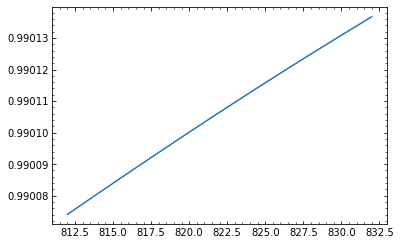

In [1062]:
ms.adap_run_steps(1500000)
print(Abar)

In [ ]:
reload(ms_hm.HM)
hm = HM(ms, mOverR=0.99, sm_sigma=50)
flag = hm.adap_run_steps(550000)
print(ms.delta, hm.BH_mass2())

In [ ]:
find_mass(0.02, is_crit=False)

In [448]:
find_mass(0.2728846216201781, is_crit=False)

Finding mass with amp 0.2728846216201781
Not Tracing ray and NO excision will be performed!
Warning, the time step is too small!
Tracing ray is enabled and excision will be performed!
Photon has gone out of the outter boundary!


ValueError: Cannot get the target 2m/R with the amplitude 0.2728846216201781

In [14]:
find_mass(0.2728846216201781, is_crit=True)

Finding mass with amp 0.2728846216201781
Not Tracing ray and NO excision will be performed!
Warning, the time step is too small!
Tracing ray is enabled and excision will be performed!
Photon has gone out of the outter boundary!
Warning, the time step is too small!
0.42650921473655545 0.46829034947396747


(0.42650921473655545, 0.46829034947396747)

In [ ]:
# Pipeline
(crit, lower) = find_crit()

lower_amp = lower + 5e-4

res=critical_scaling(crit, lower_amp, lower_amp + 1e-3, n=10)

In [108]:
crit=0.2728846216201781

In [12]:
lower_amp=crit+1e-6

In [16]:
lower_amp=0.27337198

In [ ]:
#(crit, lower_amp) = find_crit()
res = critical_scaling(crit, lower_amp, lower_amp + 1e-3, 8)

[0.27337198 0.27345479 0.27355236 0.27366732 0.27380277 0.27396237
 0.27415042 0.27437198]
Finding mass with amp 0.27337198
Not Tracing ray and NO excision will be performed!
Horizon is found, code will be terminated!
Tracing ray is enabled and excision will be performed!
Photon has gone out of the outter boundary!
2m/R is larger than 0.99
0.4273823294430452 1.148034605332311
Finding mass with amp 0.2734547890533645
Not Tracing ray and NO excision will be performed!
Horizon is found, code will be terminated!
Tracing ray is enabled and excision will be performed!
Photon has gone out of the outter boundary!
2m/R is larger than 0.99
0.427527124118255 1.204846748688422
Finding mass with amp 0.273552358712059
Not Tracing ray and NO excision will be performed!
Photon has gone out of the outter boundary!
2m/R is larger than 0.99
0.4277033295203114 1.2652040726771652
Finding mass with amp 0.27366732003465566
Not Tracing ray and NO excision will be performed!
Horizon is found, code will be term

In [93]:
find_crit()

Iteration No 0
Trying with amplitude 0.265
Not Tracing ray and NO excision will be performed!
Iteration No 1
Trying with amplitude 0.2725
Not Tracing ray and NO excision will be performed!
Iteration No 2
Trying with amplitude 0.27625
Not Tracing ray and NO excision will be performed!
Horizon is found, code will be terminated!
Iteration No 3
Trying with amplitude 0.27437500000000004
Not Tracing ray and NO excision will be performed!
Horizon is found, code will be terminated!
Iteration No 4
Trying with amplitude 0.2734375
Not Tracing ray and NO excision will be performed!
Horizon is found, code will be terminated!
Iteration No 5
Trying with amplitude 0.27296875
Not Tracing ray and NO excision will be performed!
Horizon is found, code will be terminated!
Iteration No 6
Trying with amplitude 0.272734375
Not Tracing ray and NO excision will be performed!
Warning, the time step is too small!
Iteration No 7
Trying with amplitude 0.2728515625
Not Tracing ray and NO excision will be performed!


(0.2728846216201781, 0.2728846359252929)

In [ ]:
res = critical_scaling(crit, lower_amp, lower_amp + 1e-2, 20)

[0.27337198 0.27345741 0.27355782 0.27367583 0.27381453 0.27397755
 0.27416913 0.27439431 0.27465895 0.27496999 0.27533555 0.2757652
 0.27627016 0.27686364 0.27756116 0.27838095 0.27934445 0.28047685
 0.28180776 0.28337198]
Finding mass with amp 0.27337198
Not Tracing ray and NO excision will be performed!
Horizon is found, code will be terminated!
Tracing ray is enabled and excision will be performed!
Photon has gone out of the outter boundary!
2m/R is larger than 0.99
0.4273823294430452 1.148034605332311
Finding mass with amp 0.2734574133467499
Not Tracing ray and NO excision will be performed!
Horizon is found, code will be terminated!
Tracing ray is enabled and excision will be performed!
Photon has gone out of the outter boundary!
2m/R is larger than 0.99
0.42753149745780306 1.2062082615909515
Finding mass with amp 0.27355782305799675
Not Tracing ray and NO excision will be performed!
Horizon is found, code will be terminated!
Tracing ray is enabled and excision will be performed!

In [111]:
res2

(array([[0.42738233, 1.14803461],
        [0.42773956, 1.27594266],
        [0.42823779, 1.42151099],
        [0.42893848, 1.58691422],
        [0.42992537, 1.77564082],
        [0.43130684, 1.99096766],
        [0.43326321, 2.23871257],
        [0.43601007, 2.52723787],
        [0.43987987, 2.86390604],
        [0.44533904, 3.25821521]]),
 0.42650921473654746)

In [83]:
res

(array([[0.42738233, 1.14803461],
        [0.42752712, 1.20484675],
        [0.42770333, 1.26520407],
        [0.42790854, 1.33038707],
        [0.42815473, 1.39946888],
        [0.42844121, 1.47333791],
        [0.42877517, 1.55157489],
        [0.42917189, 1.63598105]]),
 0.4265539636281781)

In [ ]:
0.42650921473654746

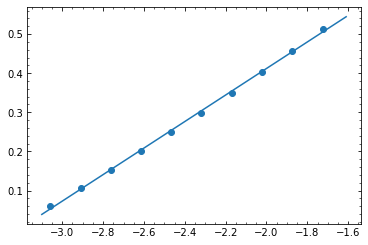

In [127]:
(a, b ) = np.polyfit(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:], deg=1)
plt.scatter(np.log10(res2[0][:,0] - res2[1])[:], np.log10(res2[0][:,1])[:])
plt.plot(np.arange(-3.1,-1.6,0.01), a * np.arange(-3.1,-1.6,0.01) + b)

In [107]:
0.4265539636281781-0.42650921473654746

4.474889163064155e-05

In [106]:
np.polyfit(np.log10(res[0][:,0] - 0.4265539636281781)[:], np.log10(res[0][:,1])[:], deg=1)

array([0.30727515, 1.00595765])

In [112]:
np.polyfit(np.log10(res2[0][:,0] - 0.42650921473654746)[:], np.log10(res2[0][:,1])[:], deg=1)

array([0.33894519, 1.08986276])

In [12]:
%%time
ms.adap_run_steps(10000)

Not Tracing ray and NO excision will be performed!
Horizon is found, code will be terminated!
CPU times: user 20.8 s, sys: 3.07 ms, total: 20.8 s
Wall time: 20.8 s


-1

In [43]:
%%time
ms.adap_run_steps(50000)

Tracing ray is enabled and excision will be performed!
Photon has gone out of the outter boundary
CPU times: user 3min 13s, sys: 13.5 ms, total: 3min 13s
Wall time: 3min 13s


0

In [105]:
np.exp(ms.xi)

228.2141912190679

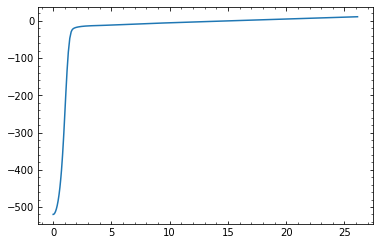

In [147]:
plt.plot(ms.Abar,ms.Abar-1/np.exp((ms.alpha-1) * ms.xi)/ms.R)

In [13]:
ms.delta

0.4260966968657298

In [138]:
ms.delta

0.4256870334507039

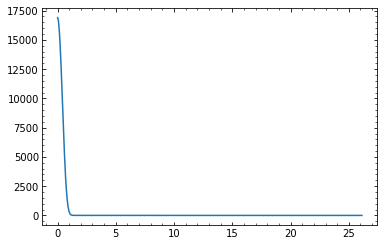

In [61]:
plt.plot(ms.Abar, ms.rho(ms.R, ms.m))
#plt.plot(ms_std.Abar[0:ms.N-1], ms_std.U_hm)

Not Tracing ray and NO excision will be performed!


/home/chit/home/chit/criticalcollapse/ms_hm/MS.py:92: RuntimeWarning: overflow encountered in exp
  ep = np.exp(self.psi(r, p, Pprime))
/home/chit/home/chit/criticalcollapse/ms_hm/MS.py:68: RuntimeWarning: invalid value encountered in subtract
  + (self.Abar * R)**2 * (U**2 - m))
/home/chit/home/chit/criticalcollapse/ms_hm/MS.py:72: RuntimeWarning: invalid value encountered in add
  return m + ms_rho_term(R, m, self.Abar)
/home/chit/home/chit/criticalcollapse/ms_hm/MS.py:68: RuntimeWarning: overflow encountered in multiply
  + (self.Abar * R)**2 * (U**2 - m))
/home/chit/home/chit/criticalcollapse/ms_hm/MS.py:102: RuntimeWarning: overflow encountered in multiply
  (self.Abar[1:]) ))  / (R * (AR_prime) * (r + p))
/home/chit/home/chit/criticalcollapse/ms_hm/MS.py:100: RuntimeWarning: invalid value encountered in true_divide
  (   g**2 * np.concatenate( ([self.w
/home/chit/home/chit/criticalcollapse/ms_hm/MS.py:103: RuntimeWarning: invalid value encountered in add
  + (2 * U**2 + m + 3 * p

(0.0, 2.0)

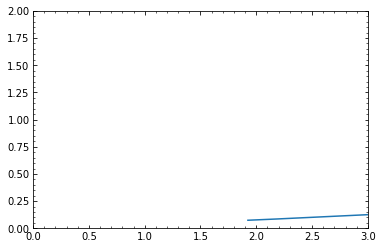

In [63]:
ms.run_steps(200)
plt.plot(ms.Abar,ms.R**2 * ms.m * ms.Abar**2 * np.exp(2 * (ms.alpha-1) * ms.xi))
plt.xlim(0,3)
plt.ylim(0,2)

In [390]:
%%time
ms.run_steps(250000)

Tracing ray is enabled and excision will be performed!
Photon has gone out of the outter boundary!
CPU times: user 19min 4s, sys: 72 ms, total: 19min 4s
Wall time: 19min 4s


0

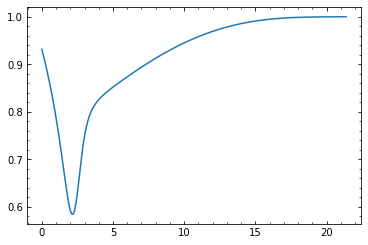

In [391]:
plt.plot(ms.Abar[0:ms.N-1], ms.U_hm )
#plt.plot(ms_std.Abar[0:ms.N-1], ms_std.U_hm)

In [381]:
import copy
ms_high_bak = copy.copy(ms)

In [413]:
hm = HM(ms, 0.99, 15)

In [309]:
hm.adap_run_steps(1000)

In [301]:
%%time
mOverR=[]
for i in range(5000):
    hm.adap_run_steps(10)
    mOverR.append(( hm.R**2 * hm.m * hm.Abar**2 * np.exp(2*(hm.alpha-1)*hm.xi)).max() )

Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
Warning, the time step is too small!
W

KeyboardInterrupt: 

In [414]:
%%time
mOverR=[]
for i in range(50):
    hm.adap_run_steps(1000)
    #plt.plot((hm.Abar), hm.U)
    #plt.show()
    mOverR.append(( hm.R**2 * hm.m * hm.Abar**2 * np.exp(2*(hm.alpha-1)*hm.xi)).max() )

2m/R is larger than 0.99
2m/R is larger than 0.99
2m/R is larger than 0.99
2m/R is larger than 0.99
2m/R is larger than 0.99
2m/R is larger than 0.99
2m/R is larger than 0.99
2m/R is larger than 0.99
2m/R is larger than 0.99
2m/R is larger than 0.99
2m/R is larger than 0.99
2m/R is larger than 0.99
2m/R is larger than 0.99
2m/R is larger than 0.99
2m/R is larger than 0.99
2m/R is larger than 0.99
CPU times: user 22min 48s, sys: 96 ms, total: 22min 48s
Wall time: 22min 48s


(-80.0, 10.0)

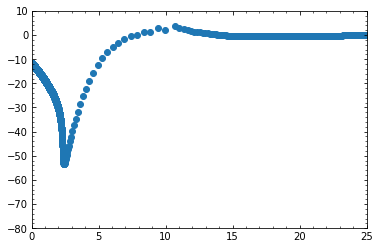

In [427]:
plt.scatter((hm.Abar*hm.R * np.exp((hm.alpha) * hm.xi)), hm.U)
#plt.plot((hm_uni.Abar), hm_uni.U)



plt.xlim(0,25)
plt.ylim(-80,10)
#plt.yscale('log')

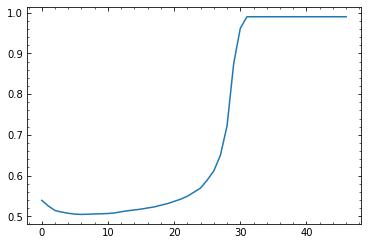

In [415]:
plt.plot(mOverR[3:])


(0.0, 1.0)

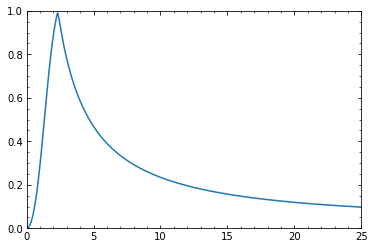

In [416]:
plt.plot((hm.Abar*hm.R * np.exp((hm.alpha) * hm.xi)), hm.R**2 * hm.m * hm.Abar**2 * np.exp(2*(hm.alpha-1)*hm.xi))
#plt.plot(hm.Abar, hm_bak.R**2 * hm_bak.m * hm_bak.Abar**2 * np.exp(2*(hm_bak.alpha-1)*(hm_bak.xi)))

plt.xlim(0,25)
plt.ylim(0.,1)

In [417]:
hm.BH_mass2()

1.148034605332311

In [406]:
hm.BH_mass2()

1.1218923237461527

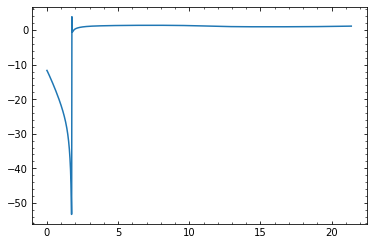

In [418]:
plt.plot((hm.Abar), hm.U)
#plt.plot((hm.Abar), hm_mix_adp_bak.U)



#plt.xlim(20,28)
#plt.ylim(-0.95,1.2)
#plt.yscale('log')

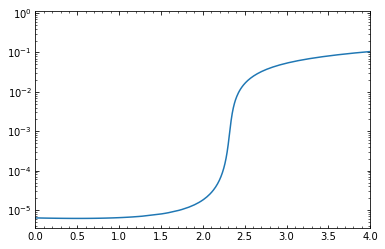

In [419]:
        xiprime = dfdA(hm.xi,  hm.Abar, 1e100)
        Rprime = dfdA(hm.R, hm.Abar, 1e100)
        mprime = dfdA(hm.m, hm.Abar, 1e100)


        
        #xiprime.fill(1)
        
        g = hm.gamma(hm.R, hm.m, hm.U, hm.xi)
        r = hm.rho(hm.R, hm.m, hm.U, hm.xi, g, xiprime, Rprime, mprime)
        drho = hm.drho(hm.R, hm.m, hm.U, g, hm.xi, Rprime, mprime, xiprime)
        exi = np.exp(hm.xi)
        ephi = hm.ephi(hm.R, hm.U, g, hm.xi, xiprime, Rprime)
        elambda = hm.elambda(ephi, exi, xiprime)
        epsi = hm.epsi(hm.R, hm.U, g, hm.xi, r, ephi)
        
        #plt.plot(np.arange(hm.N-1), ddfddA(hm.U, hm.deltaL, hm.Abar, 0)[1:])
        #plt.plot(np.arange(hm.N), dfdA(r, hm.deltaL, hm.Abar, 1e100))
        plt.plot((hm.Abar*hm.R * np.exp((hm.alpha) * hm.xi)), epsi)
        #plt.plot(np.arange(hm.N), ephi)
        #plt.plot(np.arange(hm.N), epsi)
        #plt.plot(np.arange(hm.N),elambda / epsi)
        plt.xlim(0,4)
        #plt.ylim(1e-8,1)
        plt.yscale('log')
#plt.ylim(0.915,0.93)

(0.0, 1.0)

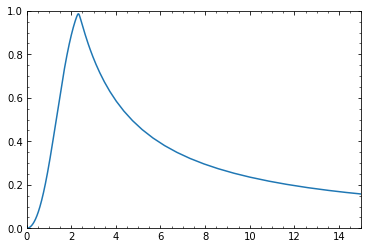

In [371]:
plt.plot((hm.Abar*hm.R * np.exp((hm.alpha) * hm.xi)), hm.R**2 * hm.m * hm.Abar**2 * np.exp(2*(hm.alpha-1)*hm.xi))
#plt.plot(hm.Abar, hm_bak.R**2 * hm_bak.m * hm_bak.Abar**2 * np.exp(2*(hm_bak.alpha-1)*(hm_bak.xi)))

plt.xlim(0,15)
plt.ylim(0.,1)

In [183]:
((np.exp(-hm.xi/2) * hm.R **3 * hm.Abar**3 * hm.m ) / 2)[(hm.R**2 * hm.m * hm.Abar**2 * np.exp(2*(hm.alpha-1)*hm.xi)).argmax()]

186.12964528729714

(0.0, 2.0)

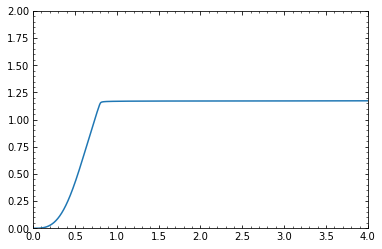

In [420]:
a = np.exp(hm.alpha * hm.xi)
H = np.exp(-hm.xi) / hm.RH
rho_b = a**(1+hm.w)
Rb = a * hm.A
plt.plot(hm.R * Rb ,  (np.exp(-hm.xi/2) * hm.R **3 * hm.Abar**3 * hm.m ) / 2 )
#plt.plot(hm.R * Rb ,  np.array([5] * hm.N) )
plt.xlim(0,4)
plt.ylim(0,2)
#plt.yscale('log')

In [17]:
hm.BH_mass()

4.3613534732611505

In [27]:
hm.BH_mass()

4.361353211290671